# MLP

This is an MLP model that explores using a single vector derived from pre-trained word embedding vectors.


Step 1: Importing the required libraries

In [240]:
import numpy as np
import pandas as pd
import re
import nltk

import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences as keras_pad_sequences

Step 2: Loading the pre-trained glove vector embedding model 

In [134]:
# Load pre-trained embedding layer
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False) # for now binary is true

Step 3: Load training and testing data

In [241]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv', delimiter=',')
X_train = df_training.values[:,0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:,0])
y_test = np.array(df_testing.values[:,1], dtype=np.float32)

Step 4: Pre-Processing training and testing data:

This phase creates a new csv file with pre-processed data that can be used by each of the models it has a few functions including: 

- Remove any punctuation
- make sentences lowercase
- Remove URL's
- Lemize words
- Tokenise the words
- Remove stop words



In [229]:
# Preprocess the text: lowercase, remove special characters, tokenize
def remove_special_characters_and_tokenise(text):
    # Lower case the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = []
    for word in nltk.word_tokenize(text):
        tokens.extend(re.findall(r'\b\w+\b', word))  # Split combined words into separate tokens
    return tokens

# Remove stopwords
def remove_stopwords(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stopwords]

# Lemmatization
def perform_lemmatization(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Clean the sentence: Apply the cleaning process to a single sentence
def clean_sentence(sentence):
    tokens = remove_special_characters_and_tokenise(sentence)
    tokens = remove_stopwords(tokens)
    tokens = perform_lemmatization(tokens)
    return tokens

# Preprocess the data: Apply the cleaning process to all sentences in data
def pre_process_data(data):
    token_arrays = []  
    for sentence in data:
        tokens = clean_sentence(sentence)
        token_arrays.append(np.array(tokens))

    return [' '.join(tokens) for tokens in token_arrays]

In [230]:
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

Tokenise the keras words

In [242]:
# Create a tokenizer to convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [243]:
def my_pad_sequences(data, max_len): 
    padded_data = keras_pad_sequences(data, maxlen=max_len, padding='post', dtype='float32')
    return np.array(padded_data)

In [244]:
max_len = max([len(sentence) for sentence in X_train])
X_train = my_pad_sequences(X_train, max_len)
X_test = my_pad_sequences(X_test, max_len)

Create token embeddings for each of the pre-processed words using pre-trained word vectors glove

In [245]:
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

In [246]:
X_train_glove_embedded = embed_text_glove(X_train, word_index) 
X_test_glove_embedded = embed_text_glove(X_test, word_index)

Create a function which creates the model

In [250]:
# flatten the embeddings vector represenetaiton
flattend_training_data = X_train_glove_embedded.reshape(X_train_glove_embedded.shape[0], -1)

# Define the MLP model
model = Sequential()
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(flattend_training_data.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
learning_rate = 0.05
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
training_labels = np.array(y_train, dtype=np.float32)

# Train the model
model.fit(flattend_training_data, training_labels, epochs=100, batch_size=50, validation_split=0.2)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6373 - loss: 1289.2087 - val_accuracy: 0.7775 - val_loss: 534.5712
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6044 - loss: 505.9720 - val_accuracy: 0.7675 - val_loss: 339.8677
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6965 - loss: 442.8538 - val_accuracy: 0.7400 - val_loss: 419.7352
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6923 - loss: 432.9776 - val_accuracy: 0.6600 - val_loss: 625.4201
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6705 - loss: 478.8544 - val_accuracy: 0.7075 - val_loss: 546.5469
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7016 - loss: 491.6557 - val_accuracy: 0.7575 - val_loss: 473.9342
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6830 - loss: 481.0620 - val_accuracy: 0.7300 - val_loss: 409.1566
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6750 - lo

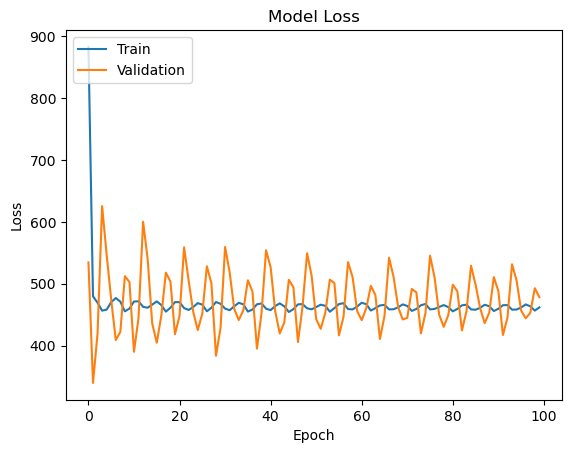

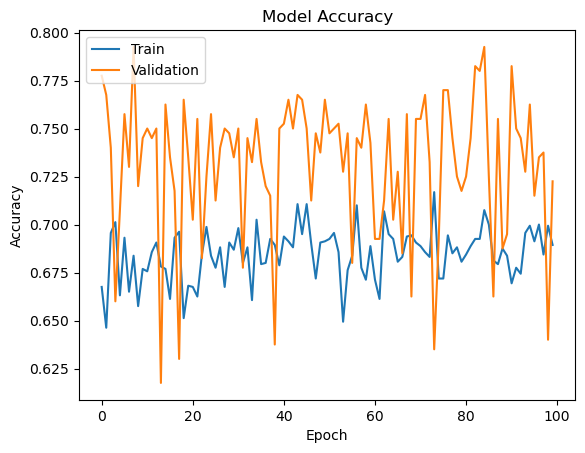

In [251]:
# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss = model.evaluate(, y_training)
print("Loss:", loss)


In [252]:
X_test_glove_embedded = X_test_glove_embedded.reshape(X_test_glove_embedded.shape[0], -1)
testing_labels = np.array(y_test, dtype=np.float32)
loss, accuracy = model.evaluate(X_test_glove_embedded, testing_labels)
print("Loss:", loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7383 - loss: 478.3569
Loss: 478.3525390625


### MLP model 2 with keras embedding layer

In [248]:
from keras.layers import Embedding

vocab_size = len(word_index) + 1  # Add 1 for the padding token
embedding_dim = 300  # Embedding dimension (should match the dimension of the pre-trained word embeddings)

# Create the MLP model with Embedding layer
model_embedding = Sequential()
model_embedding.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_embedding.add(Flatten())
model_embedding.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model_embedding.add(Dropout(0.1))
model_embedding.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model_embedding.add(Dropout(0.1))
model_embedding.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model_embedding.add(Dropout(0.1))
model_embedding.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model_embedding.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
learning_rate = 0.05
optimizer = Adam(learning_rate=learning_rate)
model_embedding.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the model
model_embedding.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2)

Epoch 1/20


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.5281 - loss: 5098.9438 - val_accuracy: 0.4875 - val_loss: 2092.7705
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.4847 - loss: 1995.0887 - val_accuracy: 0.5125 - val_loss: 1237.5164
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.5536 - loss: 1719.2371 - val_accuracy: 0.5125 - val_loss: 1584.3666
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.5362 - loss: 1659.2490 - val_accuracy: 0.5125 - val_loss: 2698.3289
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.5447 - loss: 1906.4696 - val_accuracy: 0.5125 - val_loss: 2269.9370
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.5262 - loss: 1958.1766 - val_accuracy: 0.5125 - val_loss: 1858.8552
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.5482 - loss: 1935.2262 - val_accuracy: 0.5125 - val_loss: 1386.6904
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.5331 - 

Keras embedding layer

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

fitting model
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.4830 - loss: 1621.7911 - val_accuracy: 0.4875 - val_loss: 1007.0185
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5358 - loss: 799.3845 - val_accuracy: 0.5125 - val_loss: 594.2773
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5560 - loss: 522.8149 - val_accuracy: 0.5125 - val_loss: 376.0227
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5376 - loss: 448.5011 - val_accuracy: 0.5125 - val_loss: 411.4001
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5542 - loss: 434.5820 - val_accuracy: 0.5125 - val_loss: 433.5140
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5403 - loss: 445.2852 - val_accuracy: 0.5125 - val_loss: 463.4444
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5277 - loss: 439.2642 - val_accuracy: 0.5125 - val_loss: 463.5734
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5459 - loss: 224.3335
Loss: 224.33282470703125
